# Procesamiento de datos

Importa librerías necesarias para análisis de datos y manejo de archivos.

In [1]:
import pandas as pd
import numpy as np
import glob

Buscar todos los archivos CSV en la carpeta "datasets" y carga todos los CSV en una lista de DataFrames, ignorando líneas problemáticas

In [ ]:
archivos = glob.glob("datasets/*.csv")

print("Archivos encontrados:")
for f in archivos:
    print(f)

dataframes = []
for f in archivos:
    try:
        df = pd.read_csv(f, on_bad_lines='skip')
        dataframes.append(df)
    except Exception as e:
        print(f"Error al leer {f}: {e}")


Archivos encontrados:
datasets\API_EN.GHG.FGAS.IP.MT.CE.AR5_DS2_es_csv_v2_75297.csv
datasets\API_ER.H2O.FWTL.ZS_DS2_es_csv_v2_49721.csv
datasets\API_FB.BNK.CAPA.ZS_DS2_es_csv_v2_35034.csv
datasets\API_SH.STA.SMSS.ZS_DS2_es_csv_v2_55700.csv
datasets\OWID_CB.csv
datasets\points_data.csv
datasets\WDPA_WDOECM_Aug2025_Public_HND_csv.csv


Limpieza básica de un DataFrame:
    1. Eliminar duplicados
    2. Rellenar valores nulos (texto → 'desconocido', numéricos → mediana)
    3. Convertir columnas con 'fecha' a tipo datetime

In [ ]:
def limpieza_basica(df):
    df = df.drop_duplicates()

    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].fillna("desconocido").str.strip().str.lower()
        else: 
            df[col] = df[col].fillna(df[col].median())

    for col in df.columns:
        if "fecha" in col.lower():
            df[col] = pd.to_datetime(df[col], errors="coerce")
    
    return df


 Aplicar limpieza a cada DataFrame cargado y mostrar comparativa de filas

In [4]:
dataframes_limpios = []

for archivo, df in zip(archivos, dataframes):
    df_limpio = limpieza_basica(df)
    dataframes_limpios.append(df_limpio)
    print(f"{archivo} -> Filas originales: {df.shape[0]}, Filas limpias: {df_limpio.shape[0]}")


datasets\API_EN.GHG.FGAS.IP.MT.CE.AR5_DS2_es_csv_v2_75297.csv -> Filas originales: 266, Filas limpias: 266
datasets\API_ER.H2O.FWTL.ZS_DS2_es_csv_v2_49721.csv -> Filas originales: 266, Filas limpias: 266
datasets\API_FB.BNK.CAPA.ZS_DS2_es_csv_v2_35034.csv -> Filas originales: 266, Filas limpias: 266
datasets\API_SH.STA.SMSS.ZS_DS2_es_csv_v2_55700.csv -> Filas originales: 266, Filas limpias: 266
datasets\OWID_CB.csv -> Filas originales: 3079976, Filas limpias: 3079976
datasets\points_data.csv -> Filas originales: 1375, Filas limpias: 1375
datasets\WDPA_WDOECM_Aug2025_Public_HND_csv.csv -> Filas originales: 119, Filas limpias: 119


Crear carpeta "data_limpios" y guardar allí los DataFrames limpios

In [ ]:
import os
os.makedirs("data_limpios", exist_ok=True)


for archivo, df in zip(archivos, dataframes_limpios):
    nombre = os.path.basename(archivo)  # nombre del archivo original
    df.to_csv(os.path.join("data_limpios", f"limpio_{nombre}"), index=False)

print("Archivos limpios guardados en carpeta 'data_limpios'")


✅ Archivos limpios guardados en carpeta 'data_limpios'


# Aplicacion de Tecnicas de analisis de datos

Importar librerías de visualización y configurar estilo gráfico.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

Seleccionar algunos archivos limpios específicos para análisis

In [54]:
archivos = [
    "data_limpios/limpio_API_ER.H2O.FWTL.ZS_DS2_es_csv_v2_49721.csv",
    "data_limpios/limpio_API_FB.BNK.CAPA.ZS_DS2_es_csv_v2_35034.csv",
    "data_limpios/limpio_API_EN.GHG.FGAS.IP.MT.CE.AR5_DS2_es_csv_v2_75297.csv",
    "data_limpios/limpio_API_SH.STA.SMSS.ZS_DS2_es_csv_v2_55700.csv"
]

dataframes = [pd.read_csv(f) for f in archivos]


Transformar DataFrame de formato ancho a largo:
    - Mantener columnas de identificación (país, indicador)
    - Convertir años en columna "Year"
    - Valores en columna "Value"

In [8]:
def transformar(df):
    df_long = df.melt(
        id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
        var_name="Year",
        value_name="Value"
    )
    df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")
    return df_long

dataframes_long = [transformar(df) for df in dataframes]



Gráfico de tendencia global para los csv

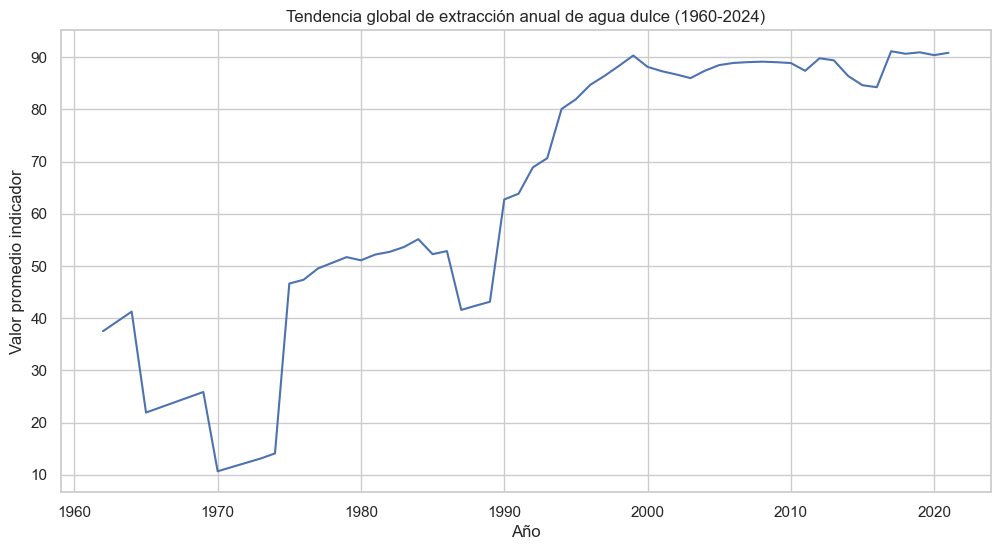

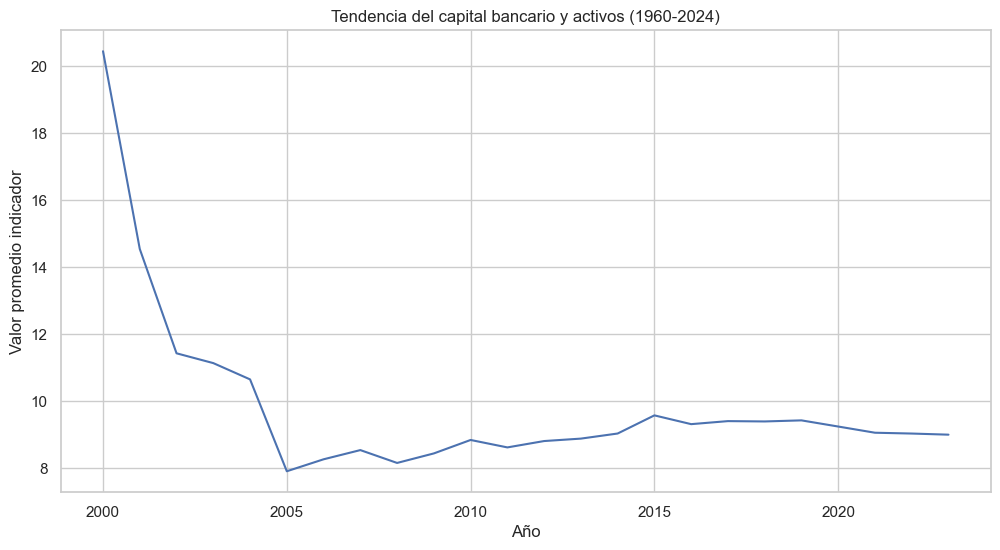

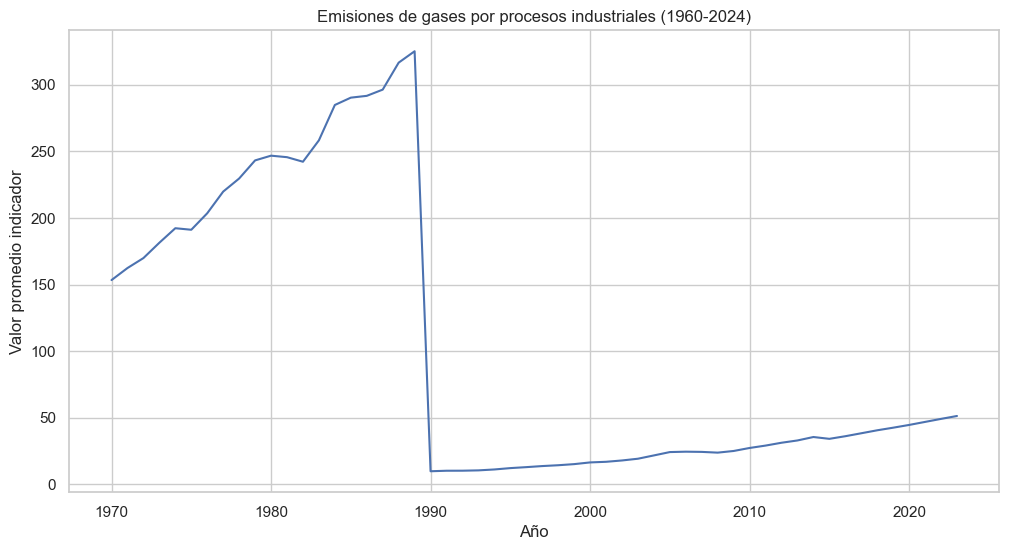

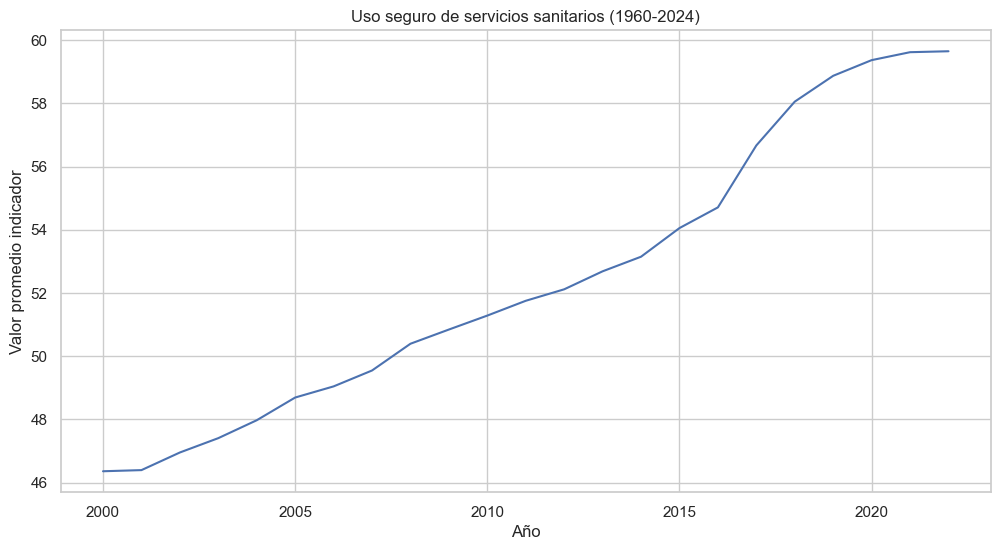

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Títulos para cada dataframe
titulos = {
    0: "Tendencia global de extracción anual de agua dulce (1960-2024)",
    1: "Tendencia del capital bancario y activos (1960-2024)",
    2: "Emisiones de gases por procesos industriales (1960-2024)",
    3: "Uso seguro de servicios sanitarios (1960-2024)"
}

# Recorrer cada dataframe y graficar
for i, df in enumerate(dataframes_long):
    trend = df.groupby("Year")["Value"].mean().reset_index()
    
    plt.figure(figsize=(12,6))
    sns.lineplot(data=trend, x="Year", y="Value")
    plt.title(titulos[i])
    plt.ylabel("Valor promedio indicador")
    plt.xlabel("Año")
    plt.show()


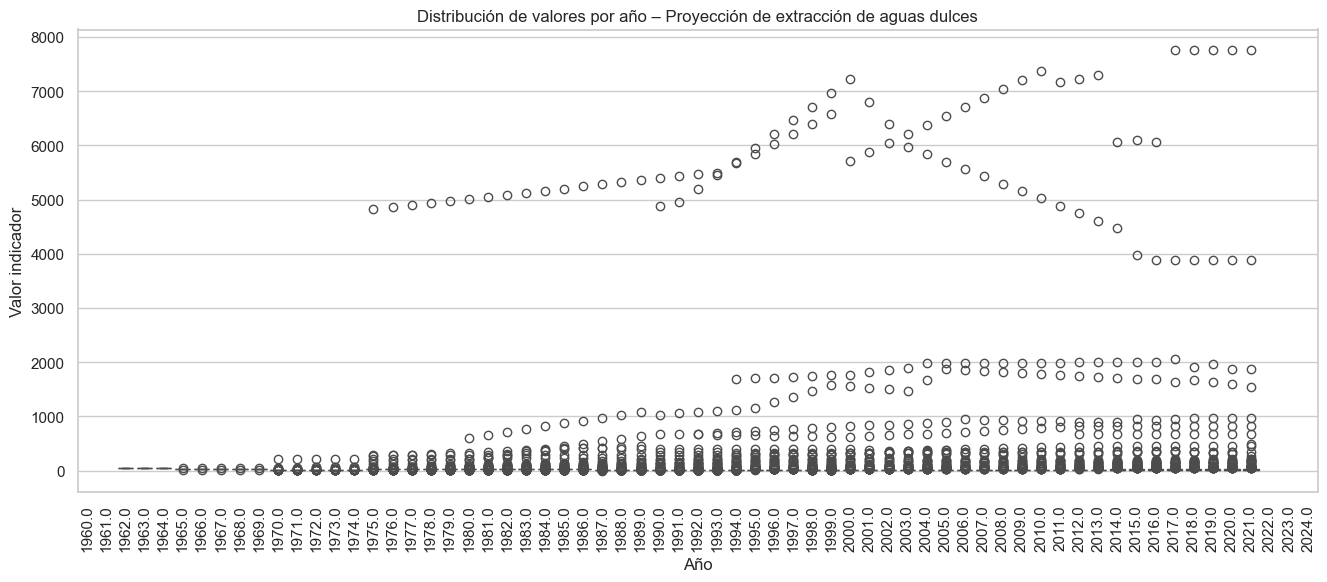

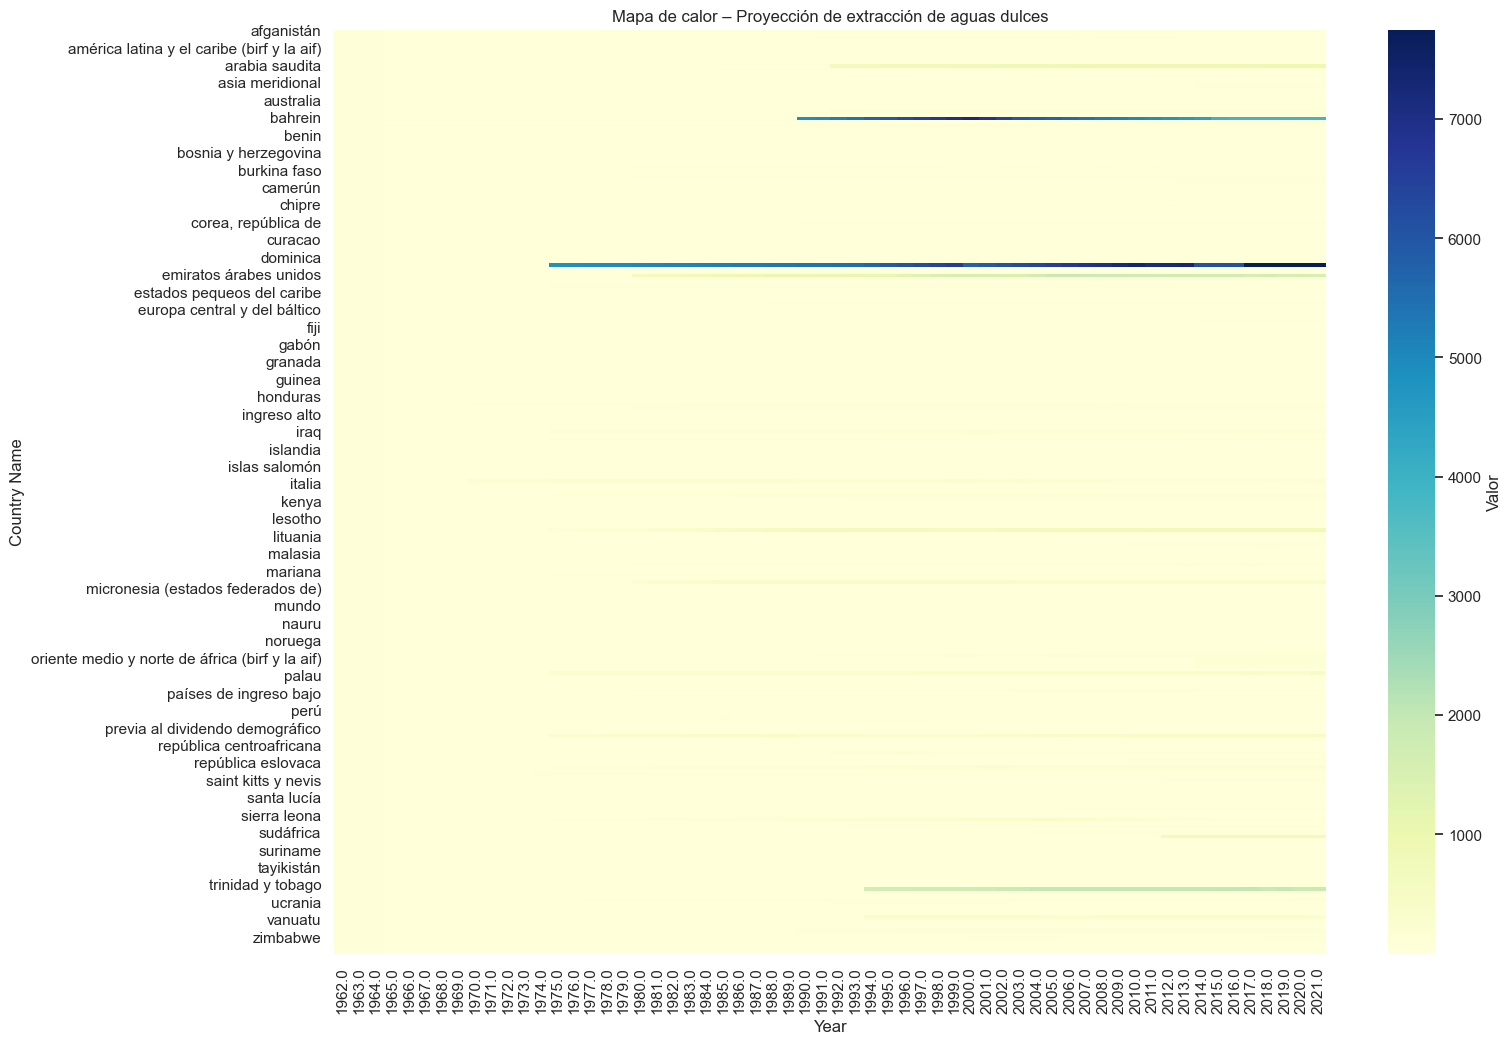

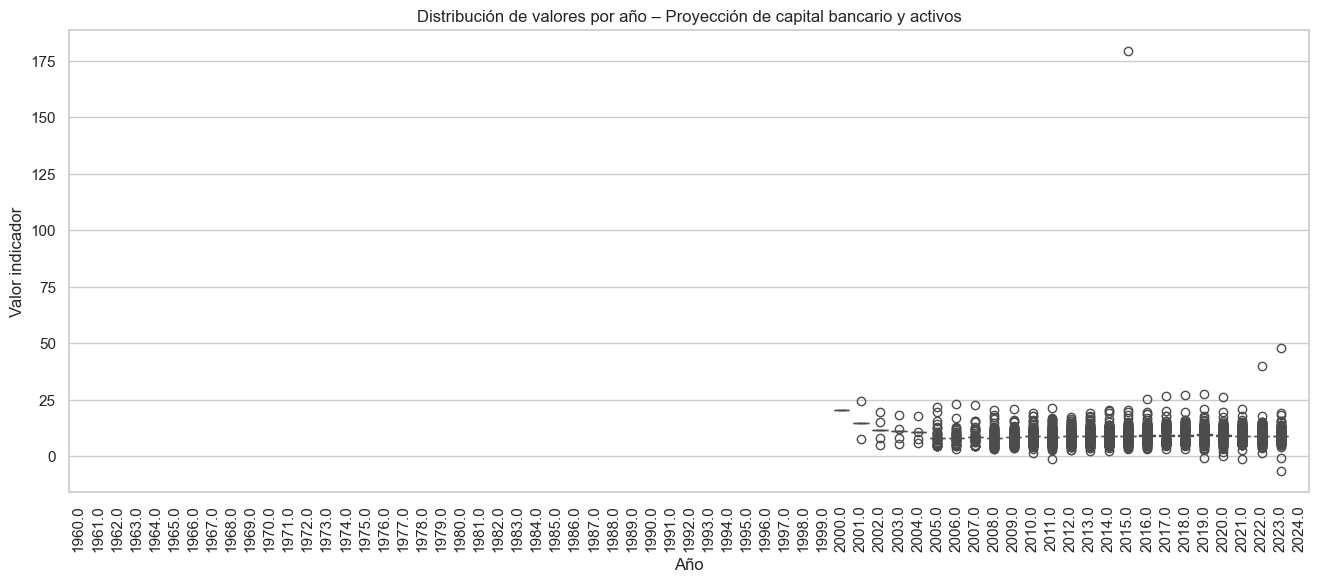

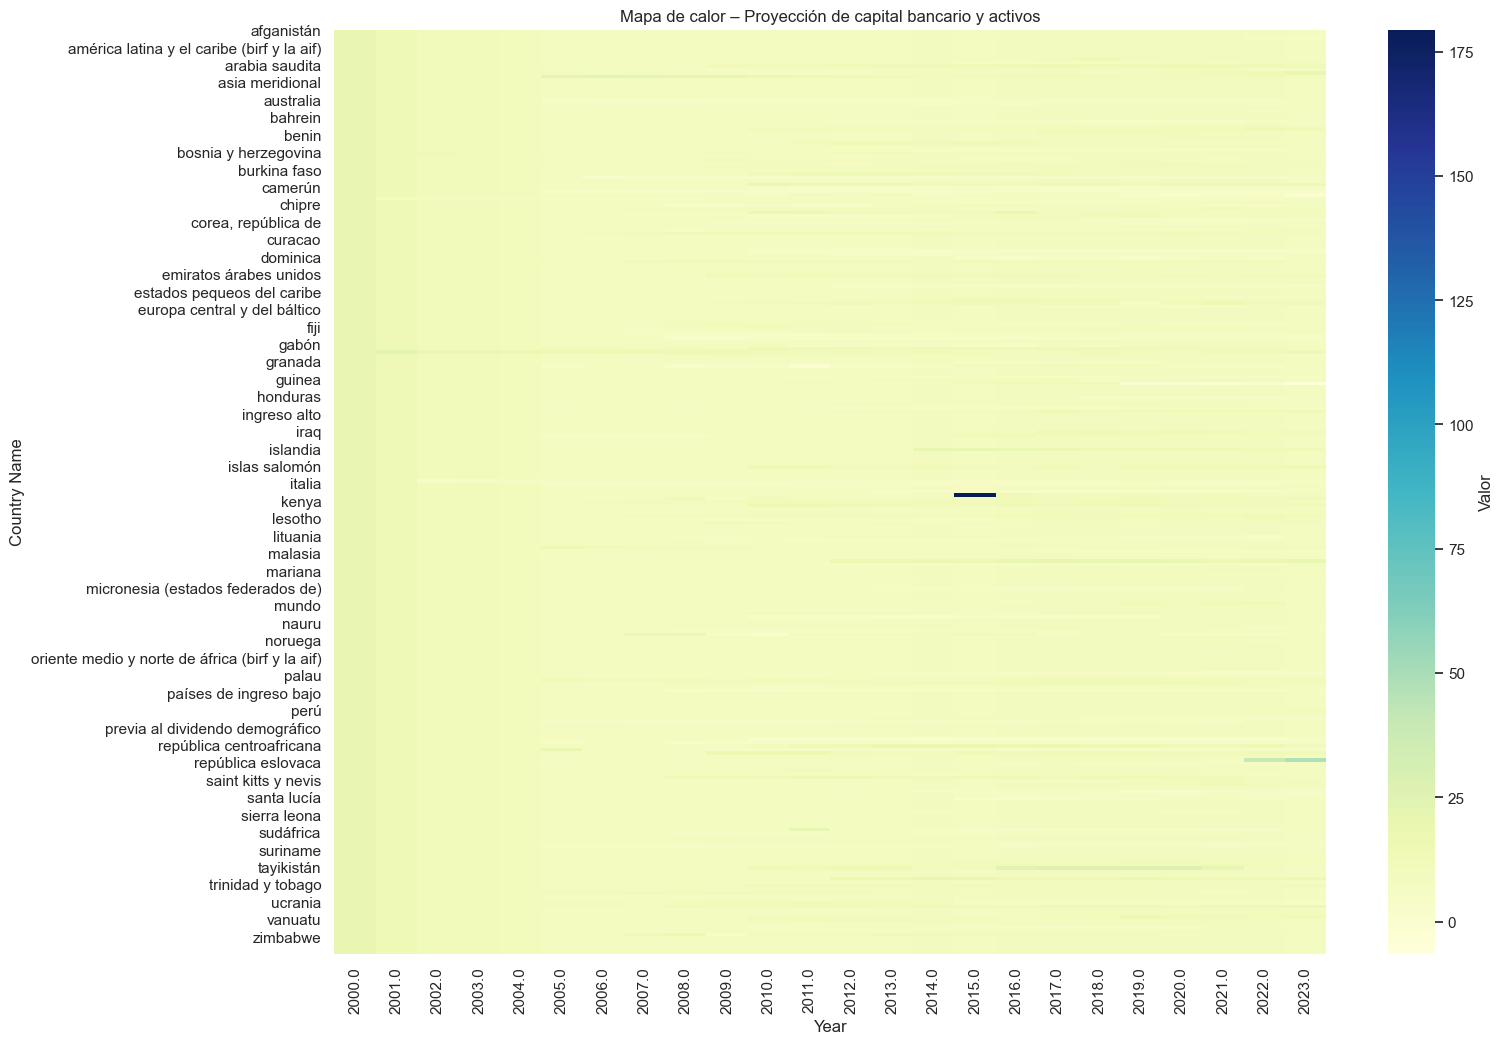

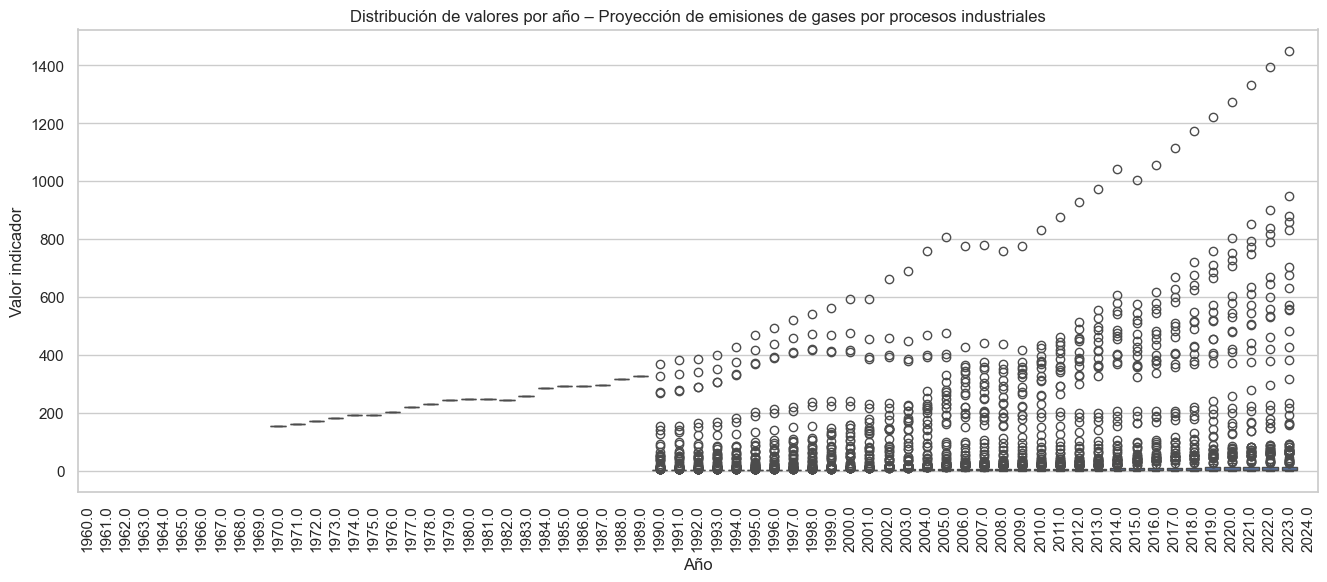

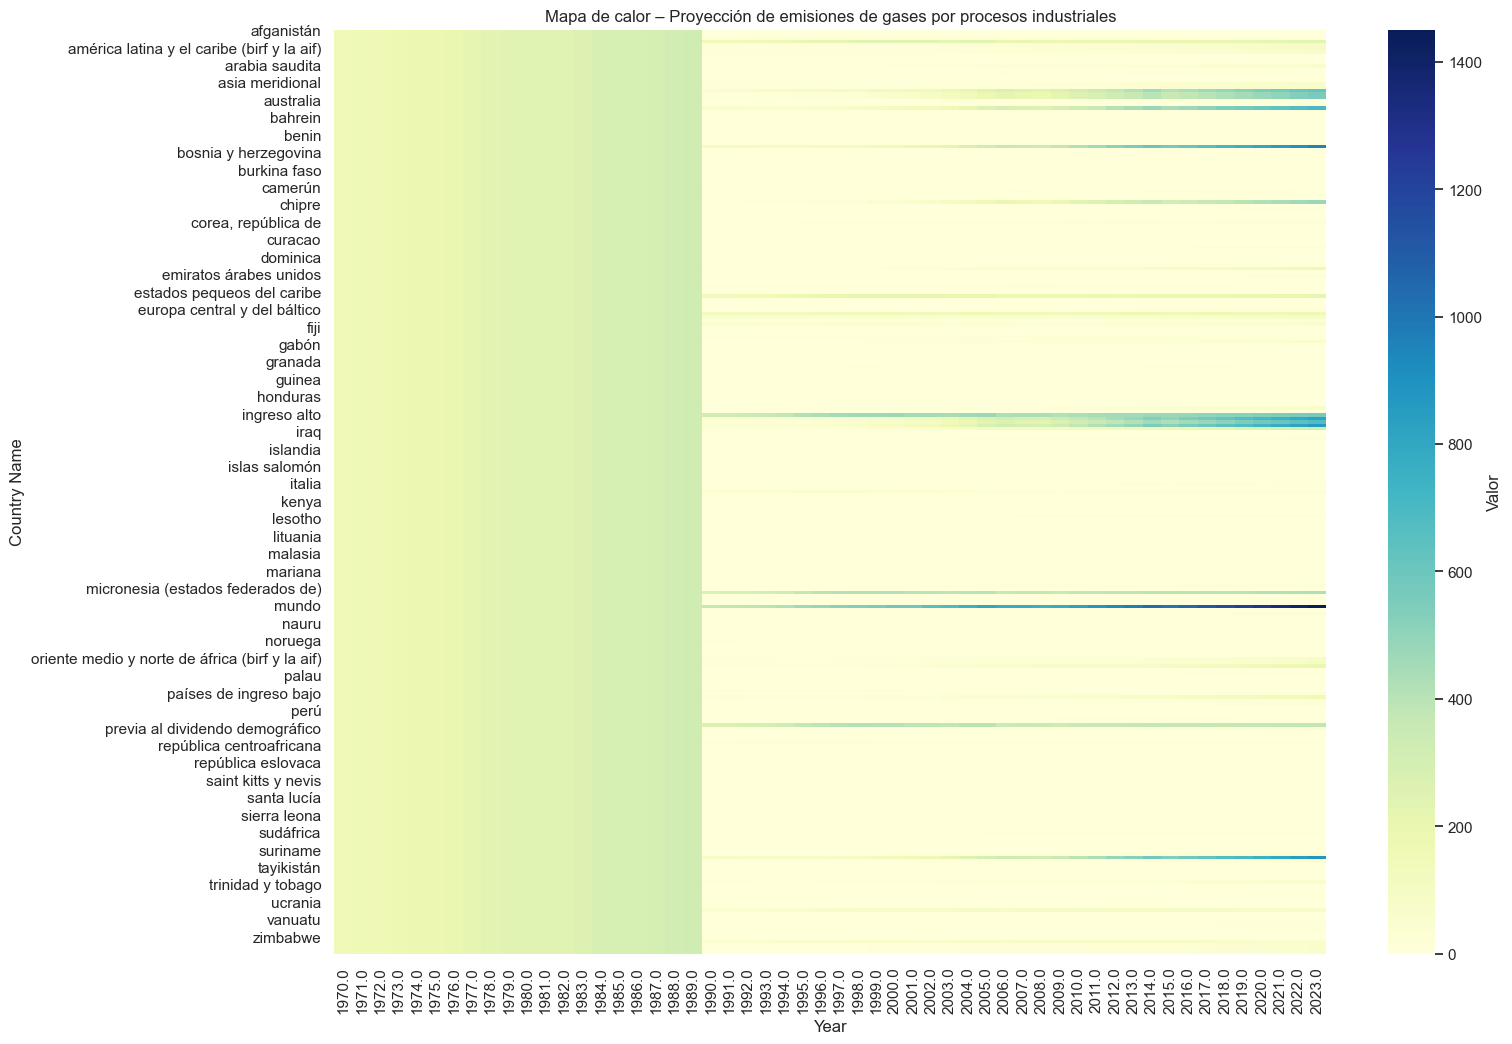

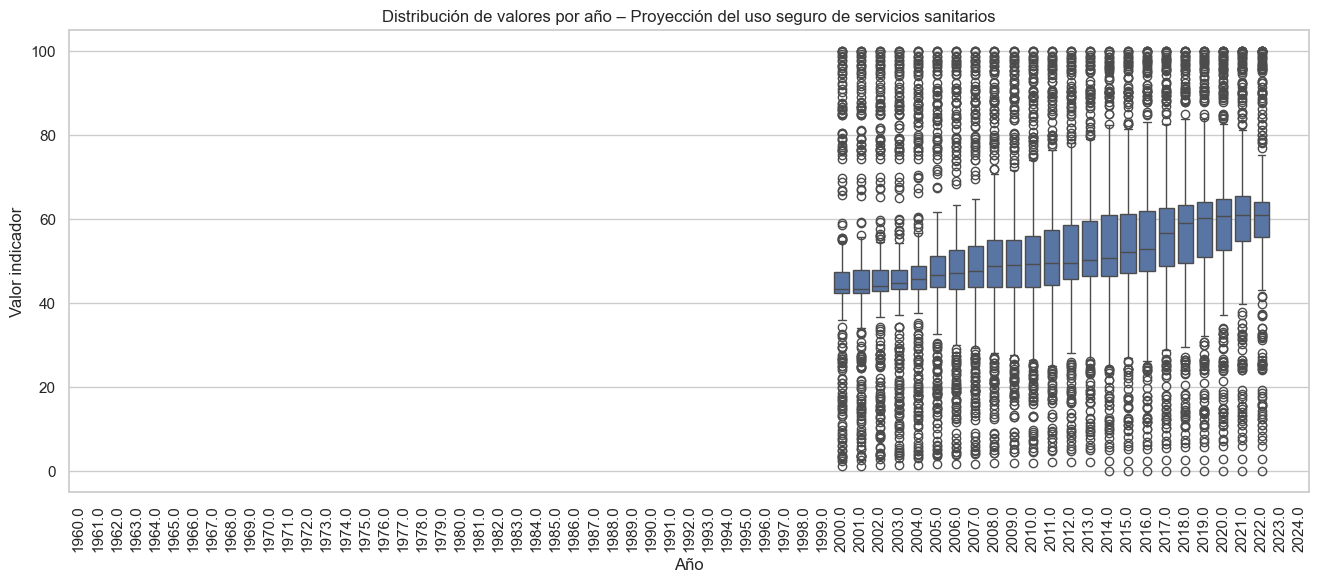

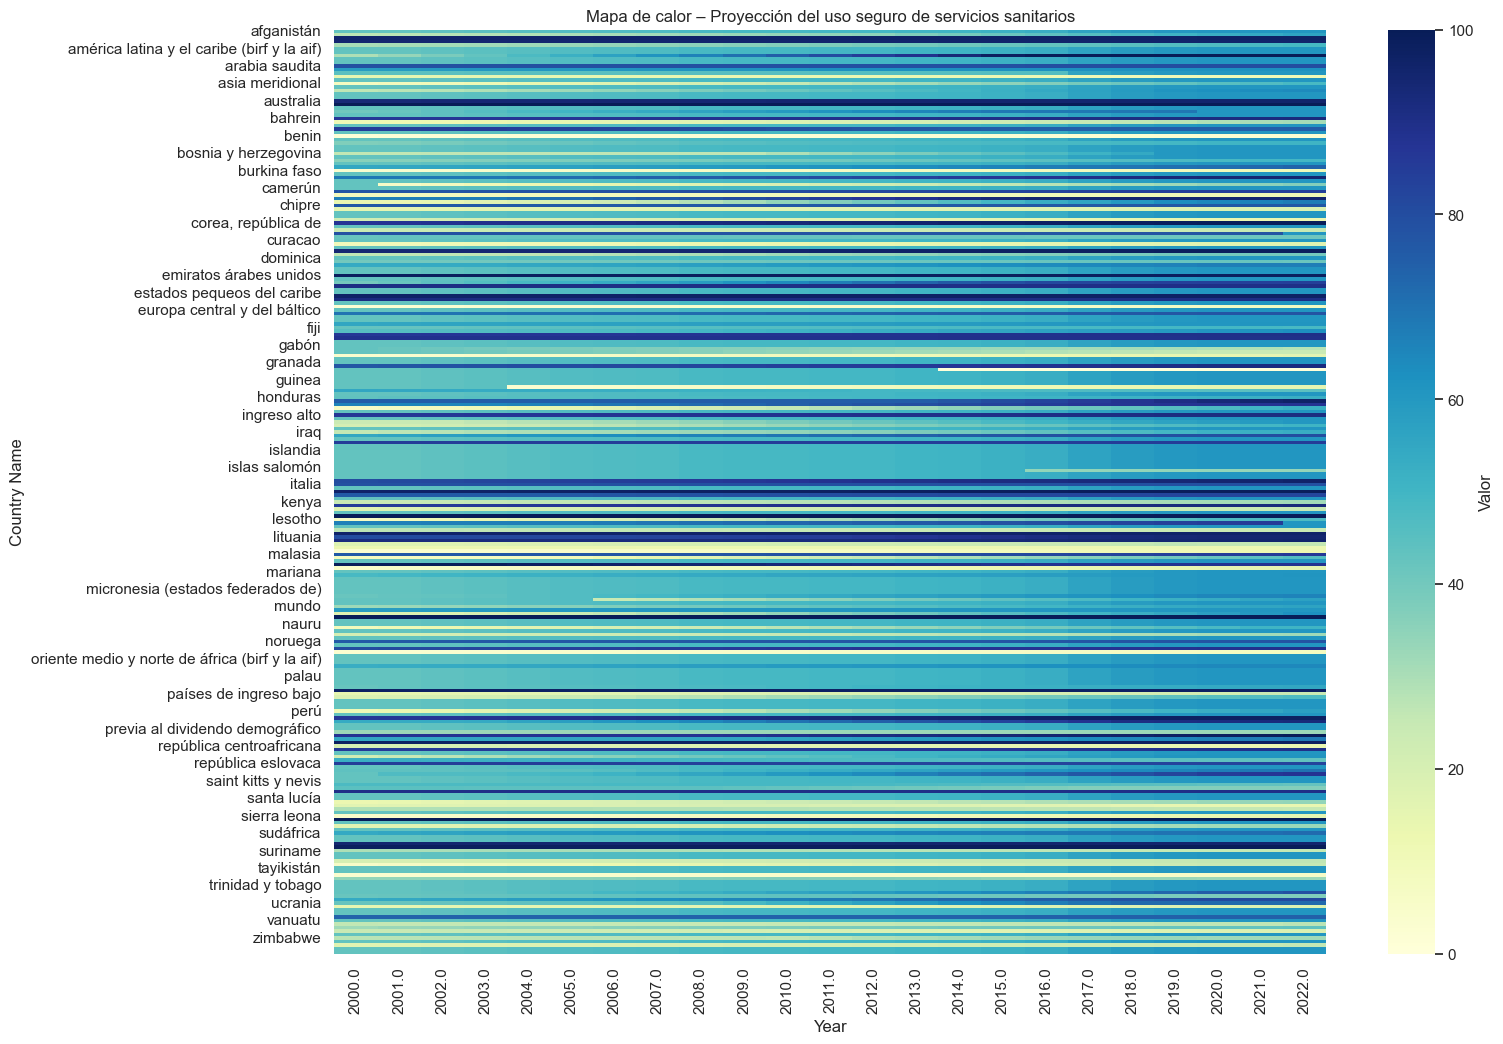

In [ ]:
years = np.arange(1960, 2025) 

for i, df in enumerate(dataframes_long):
    plt.figure(figsize=(16,6))
    
    # Filtramos los años que tenemos en el rango
    df_plot = df[df["Year"].between(1960, 2024)]
    
    sns.boxplot(data=df_plot, x="Year", y="Value")
    pivot = df_plot.pivot_table(index="Country Name", columns="Year", values="Value")
    plt.figure(figsize=(16,12))
    sns.heatmap(pivot, cmap="YlGnBu", cbar_kws={'label': 'Valor'})
    plt.title(f"Mapa de calor – {titulos[i]}")
    plt.show()

# Modelo Predictivos

Ejemplo de modelo predictivo para un país específico (Brasil)

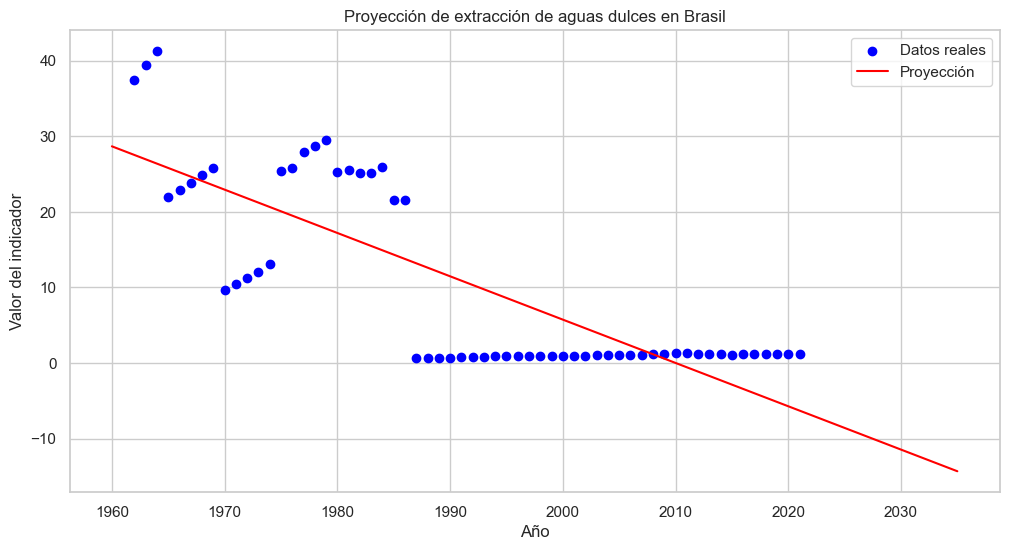

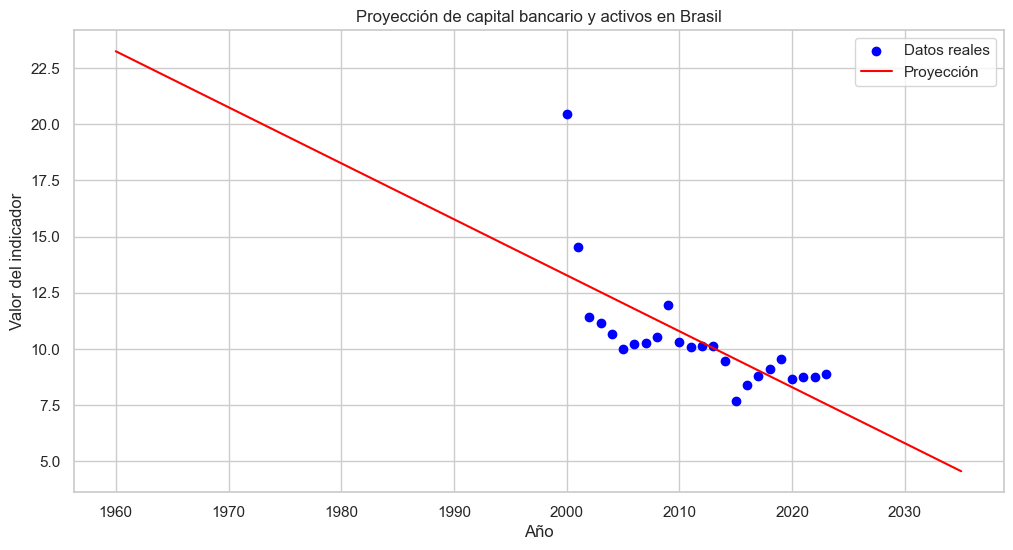

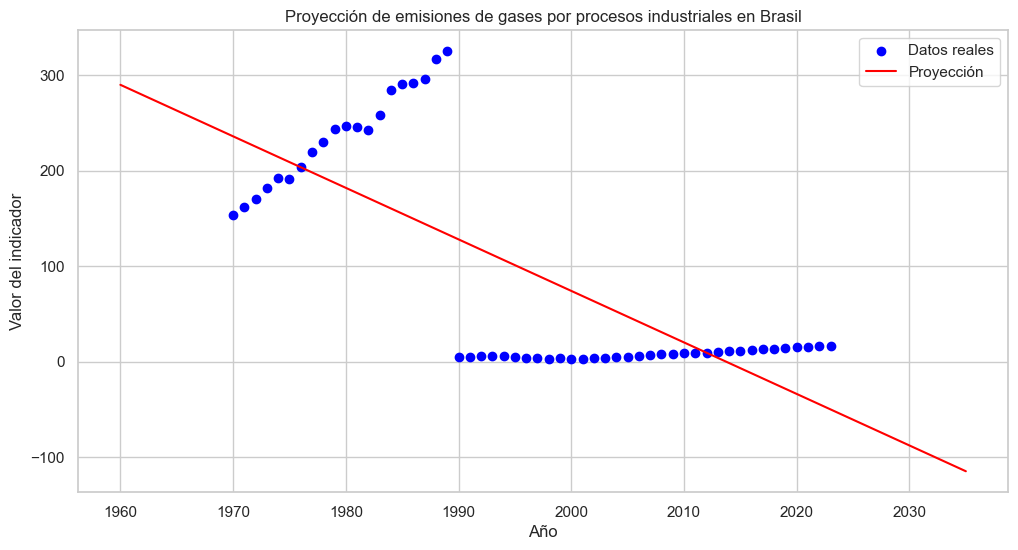

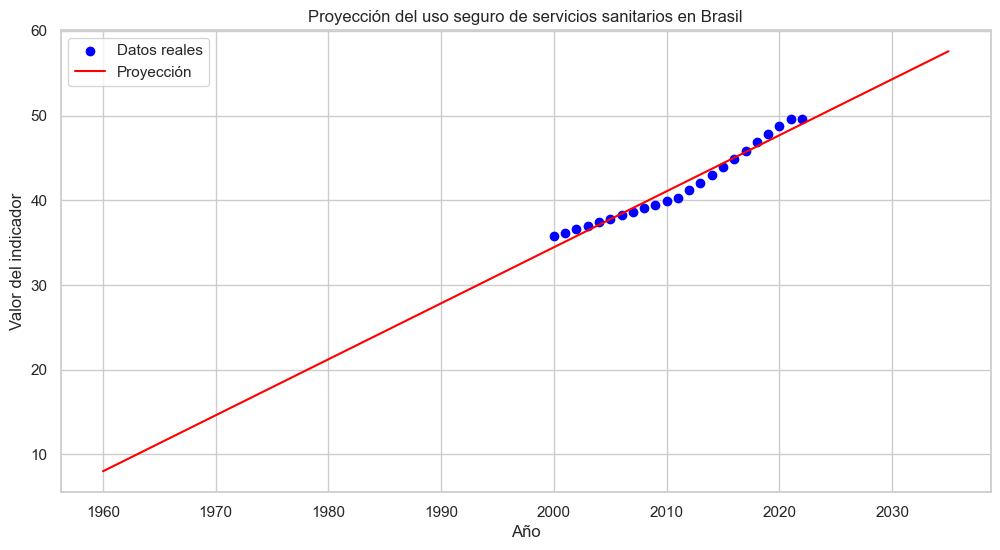

In [67]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Diccionario de títulos
titulos = {
    0: "Proyección de extracción de aguas dulces",
    1: "Proyección de capital bancario y activos",
    2: "Proyección de emisiones de gases por procesos industriales",
    3: "Proyección del uso seguro de servicios sanitarios"
}

pais = "brasil"  # << Aquí cambias el país que quieras

for i, df in enumerate(dataframes_long):
    df_pais = df[df["Country Name"] == pais].dropna(subset=["Value"])
    
    if df_pais.empty:
        print(f"No hay datos disponibles para {pais} en el indicador {i}")
        continue
    
    X = df_pais["Year"].values.reshape(-1,1)
    y = df_pais["Value"].values

    # Entrenar modelo
    model = LinearRegression()
    model.fit(X, y)

    # Proyectar hasta 2035
    future_years = np.arange(1960, 2036).reshape(-1,1)
    y_pred = model.predict(future_years)

    # Visualización
    plt.figure(figsize=(12,6))
    plt.scatter(X, y, label="Datos reales", color="blue")
    plt.plot(future_years, y_pred, color="red", label="Proyección")
    plt.title(f"{titulos[i]} en {pais.capitalize()}")
    plt.xlabel("Año")
    plt.ylabel("Valor del indicador")
    plt.legend()
    plt.show()


Configuración global para proyecciones

In [71]:
anio_horizonte = 2035
indicador_es_perdida = True 
min_puntos_por_pais = 5 


indicadores = {
    0: "agua_dulce",
    1: "capital_bancario",
    2: "emisiones_industriales",
    3: "servicios_sanitarios"
}

 Ajusta un modelo lineal para un país y devuelve métricas clave:
    - Último valor observado
    - Predicción para 2030 y 2035
    - Pendiente (tendencia)
    - Cambio proyectado al 2035

In [72]:
def proyectar_pais(df_pais, anio_hasta=2035):
    df_pais = df_pais.dropna(subset=["Value"]).sort_values("Year")
    if df_pais.shape[0] < 2:
        return None
    
    X = df_pais["Year"].values.reshape(-1, 1)
    y = df_pais["Value"].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    anio_ultimo = int(df_pais["Year"].max())
    val_ultimo = float(df_pais.loc[df_pais["Year"] == anio_ultimo, "Value"].iloc[0])
    
    def pred(anio): 
        return float(model.predict(np.array([[anio]]) )[0])
    
    y2030 = pred(2030) if 2030 >= df_pais["Year"].min() else np.nan
    y2035 = pred(anio_hasta)
    
    pendiente = float(model.coef_[0])
    delta_2035 = y2035 - val_ultimo 
    
    return {
        "anio_min": int(df_pais["Year"].min()),
        "anio_max": anio_ultimo,
        "valor_ultimo": val_ultimo,
        "y2030": y2030,
        "y2035": y2035,
        "pendiente_por_anio": pendiente,
        "delta_2035_vs_ultimo": delta_2035
    }


In [73]:
os.makedirs("salidas_modelado", exist_ok=True)

 Aplicar proyecciones a todos los países y construir DataFrame con resultados


>>> Procesando indicador 0: agua_dulce
Países modelados: 265
Guardado: salidas_modelado/proyecciones_lineales_2035_agua_dulce.csv


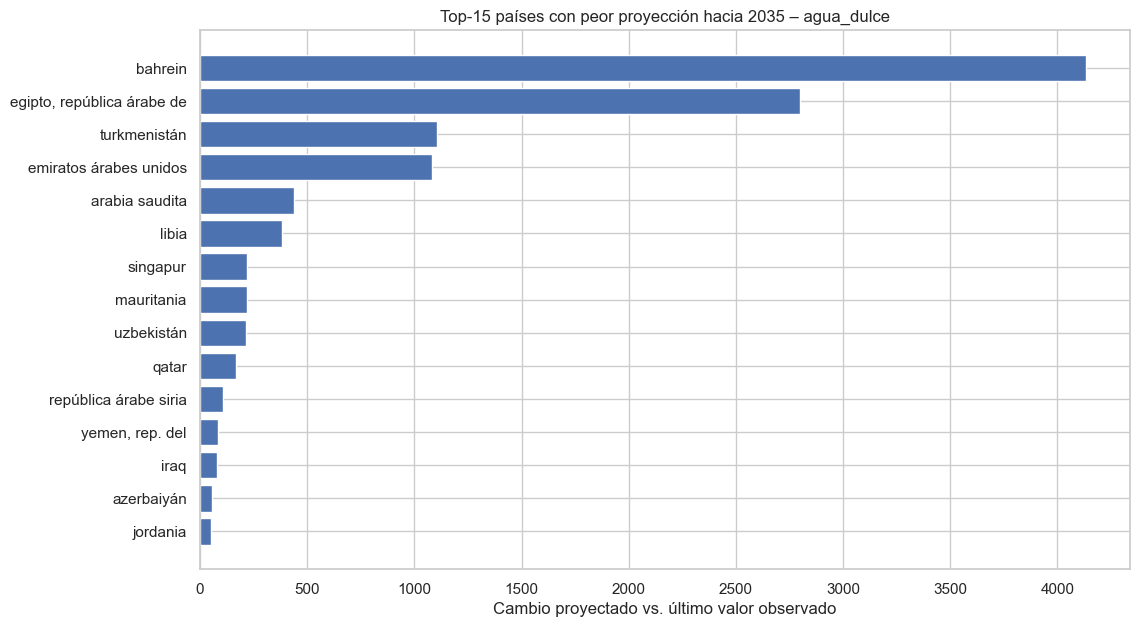

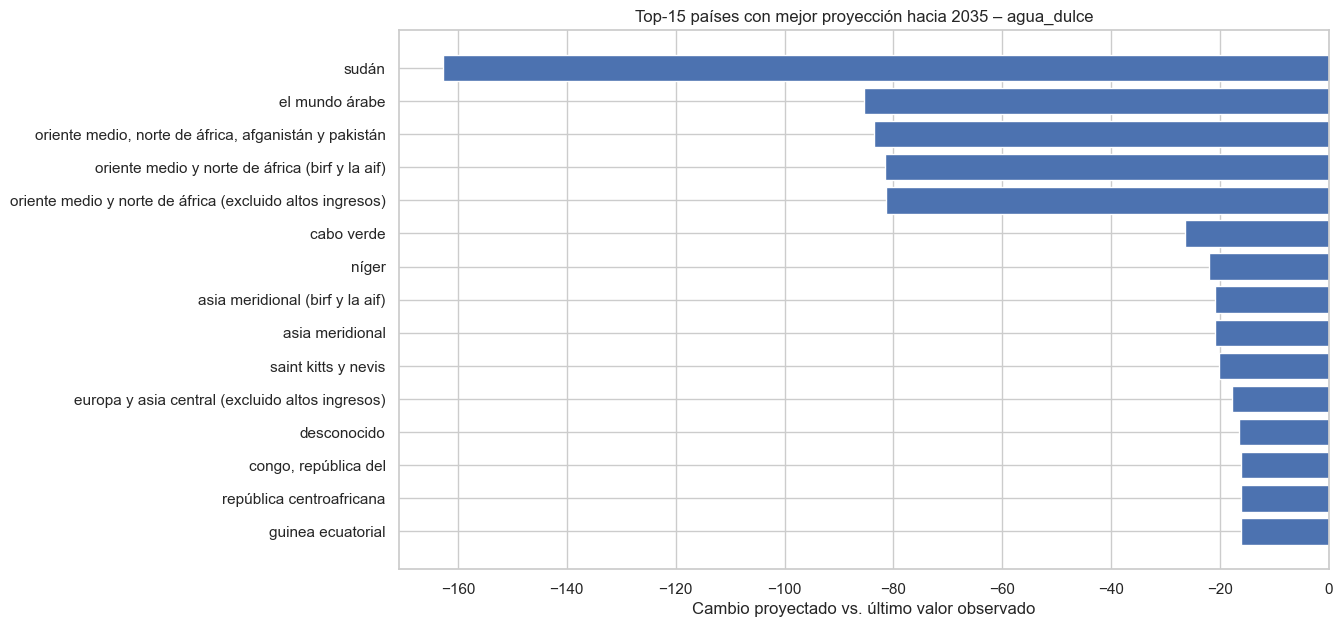

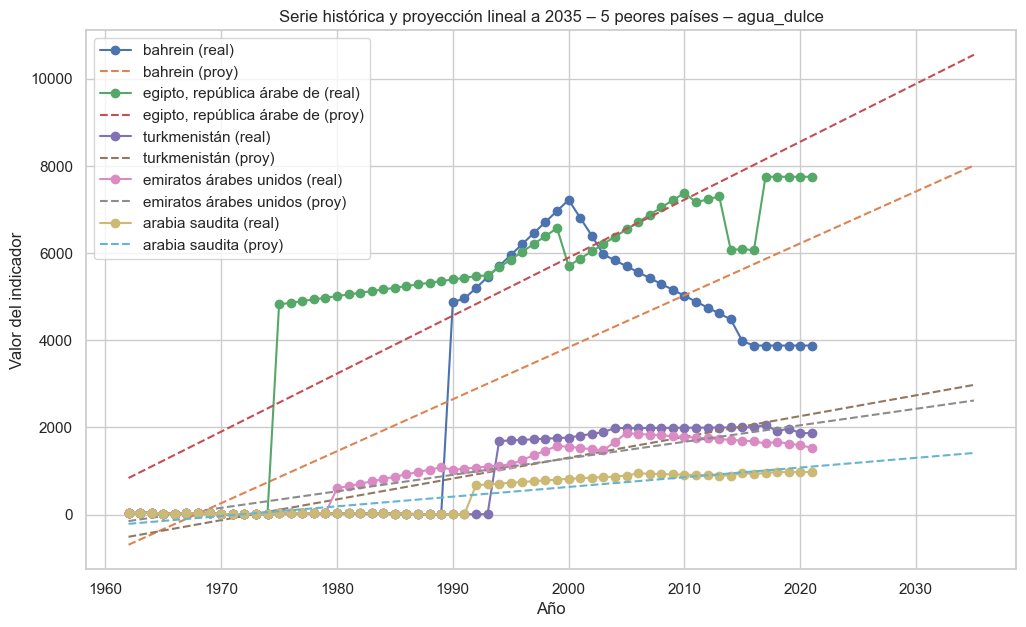

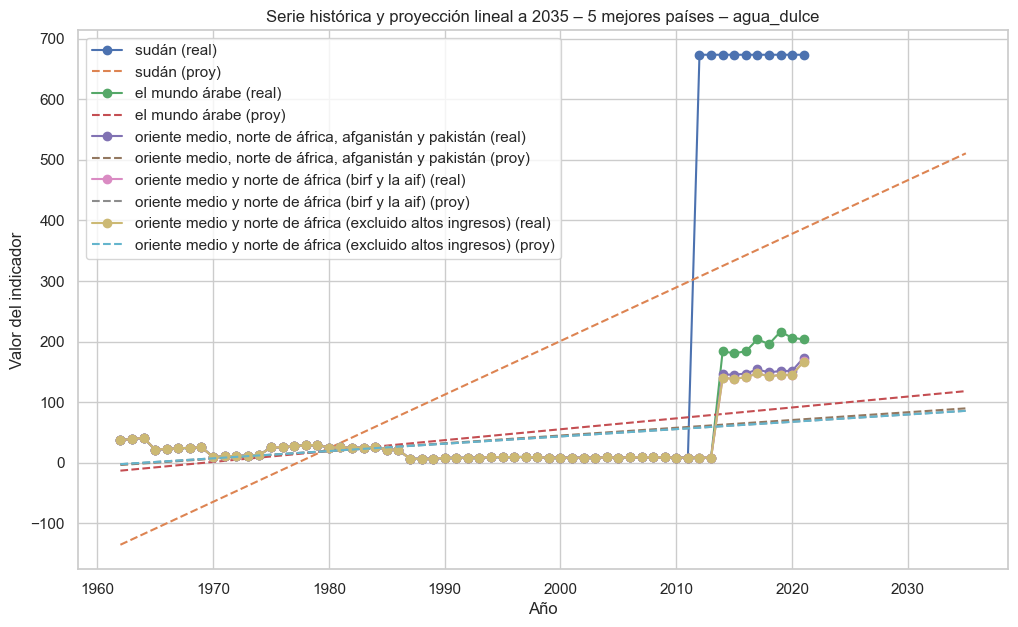


>>> Procesando indicador 1: capital_bancario
Países modelados: 265
Guardado: salidas_modelado/proyecciones_lineales_2035_capital_bancario.csv


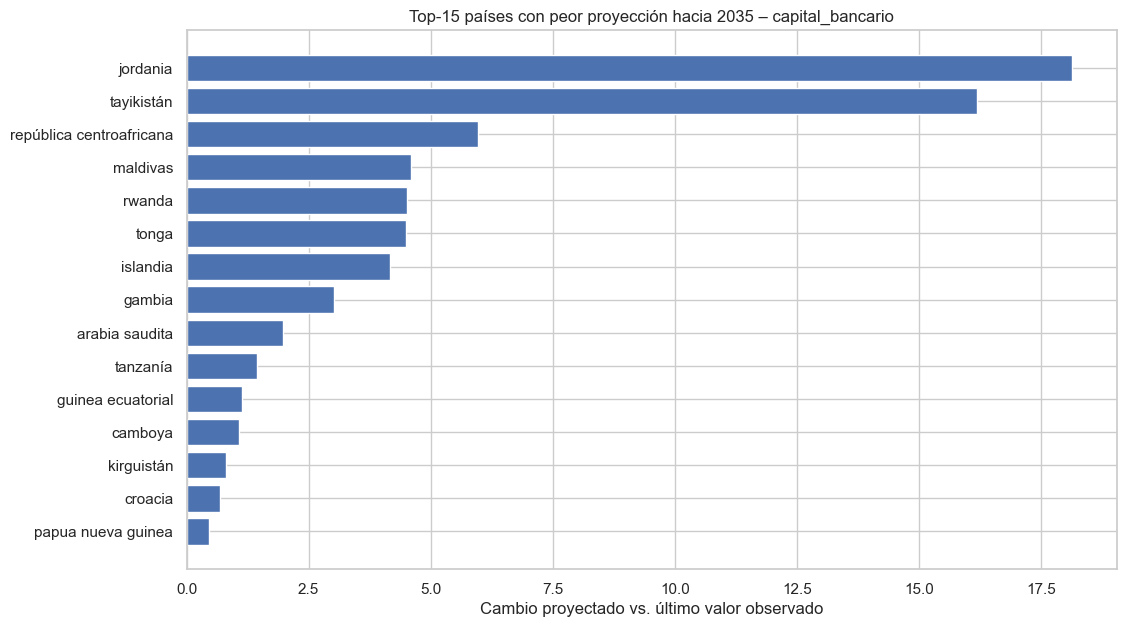

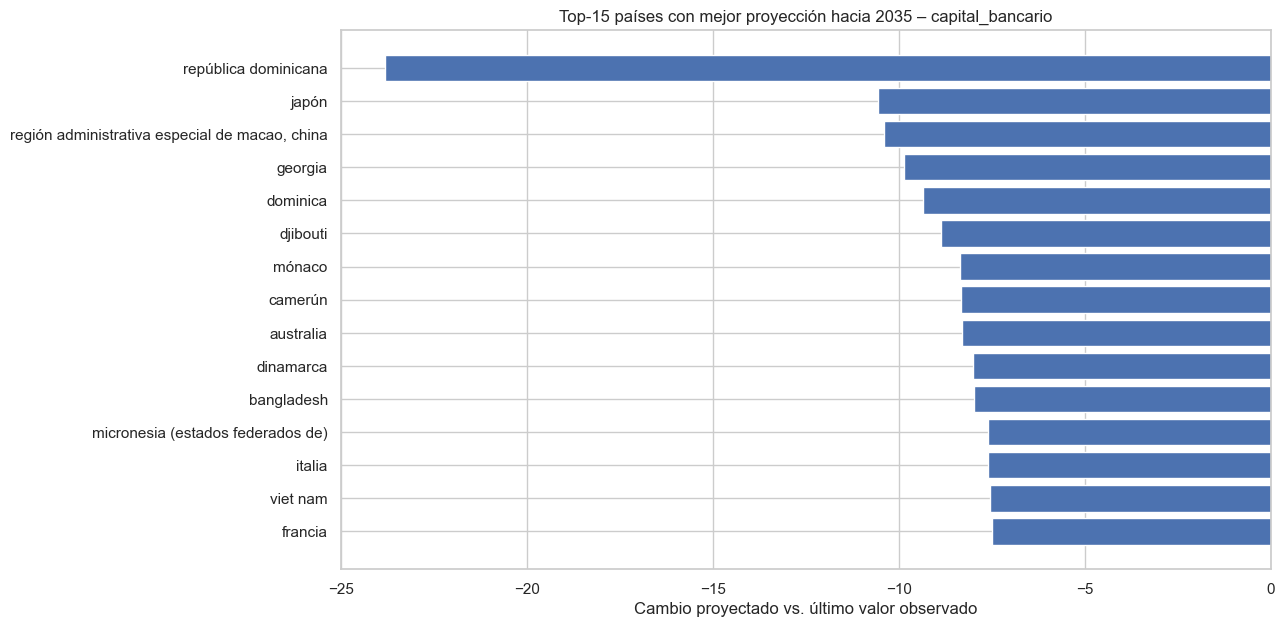

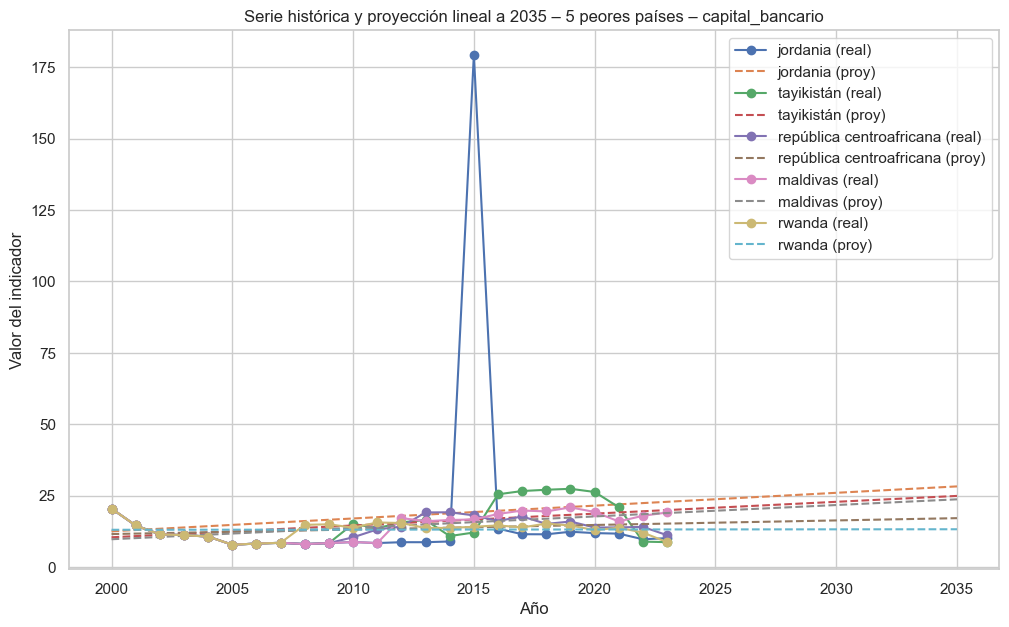

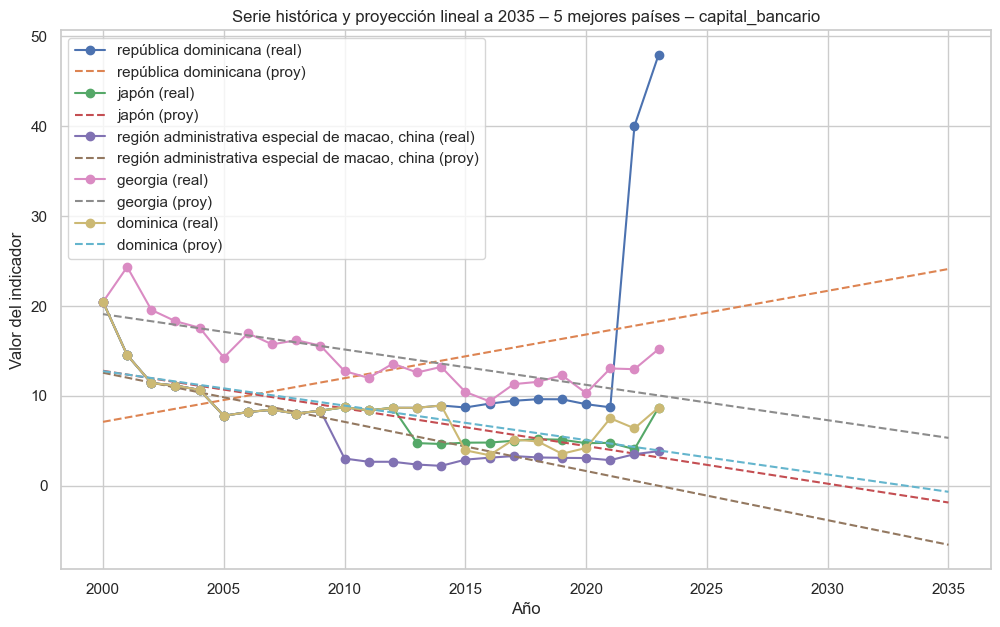


>>> Procesando indicador 2: emisiones_industriales
Países modelados: 265
Guardado: salidas_modelado/proyecciones_lineales_2035_emisiones_industriales.csv


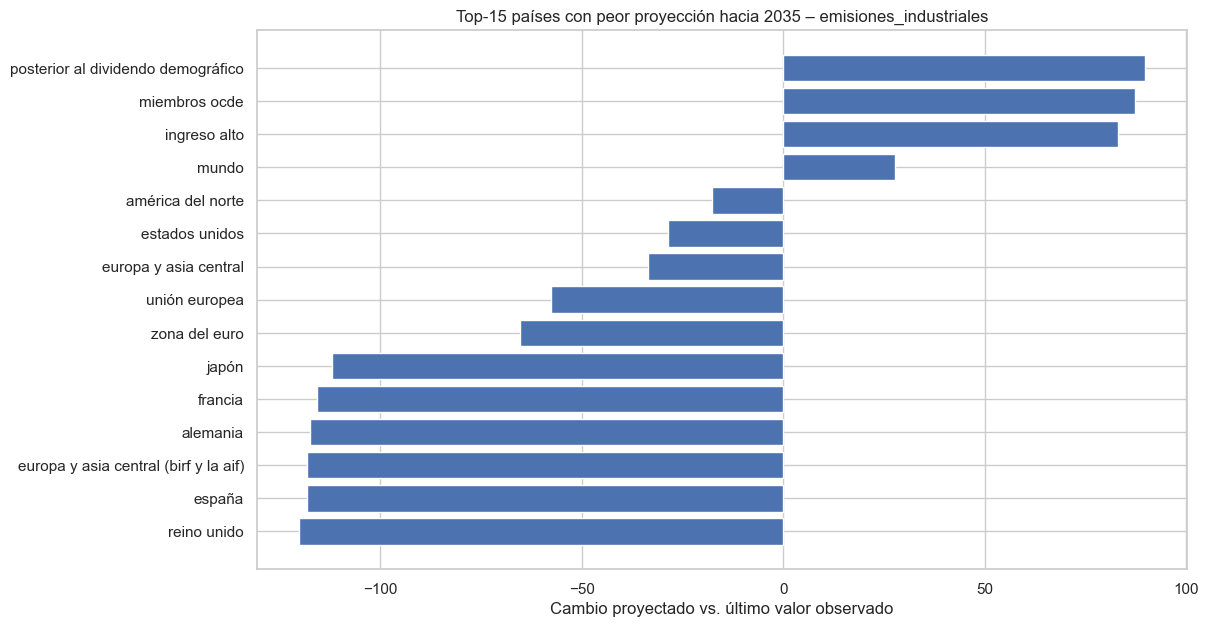

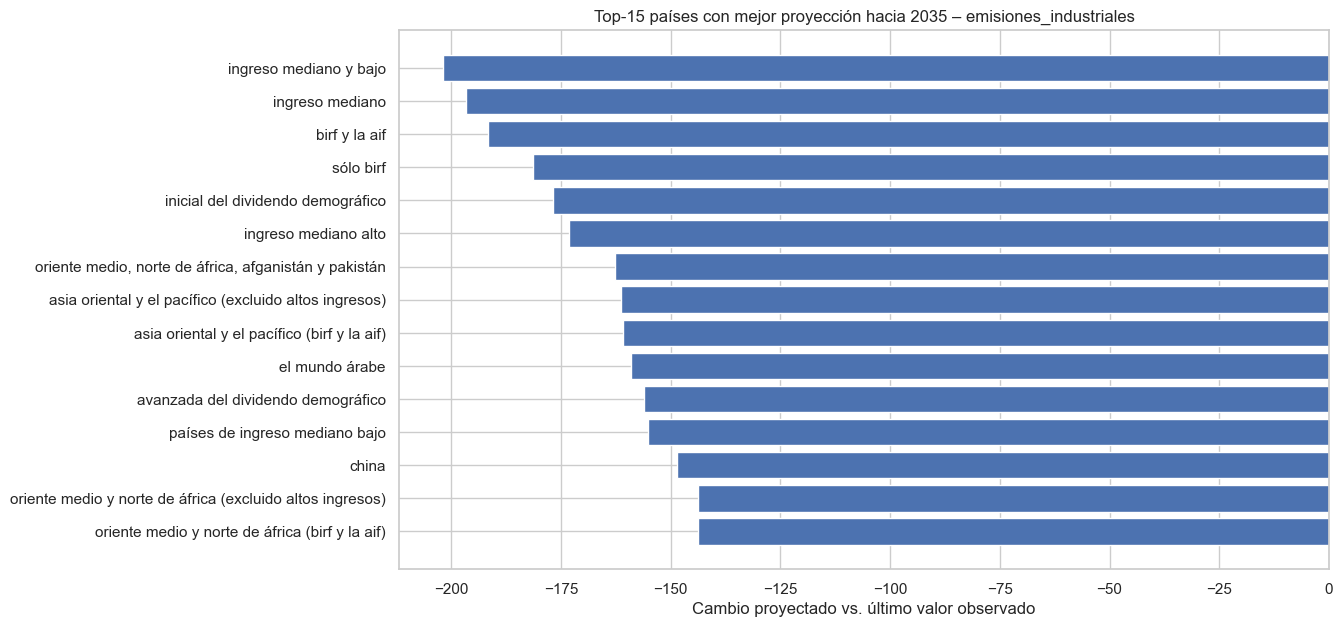

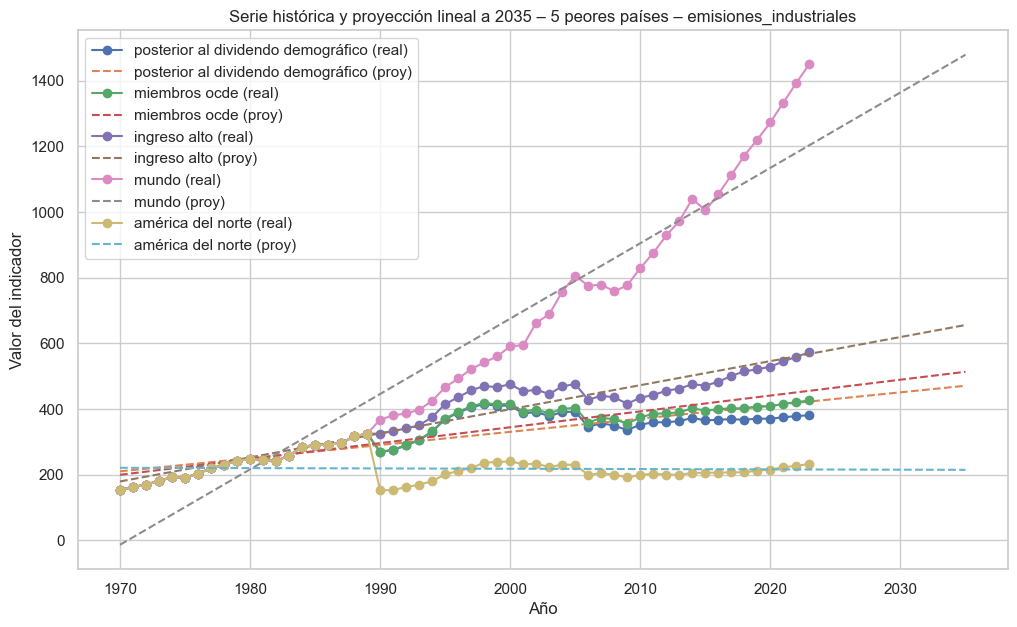

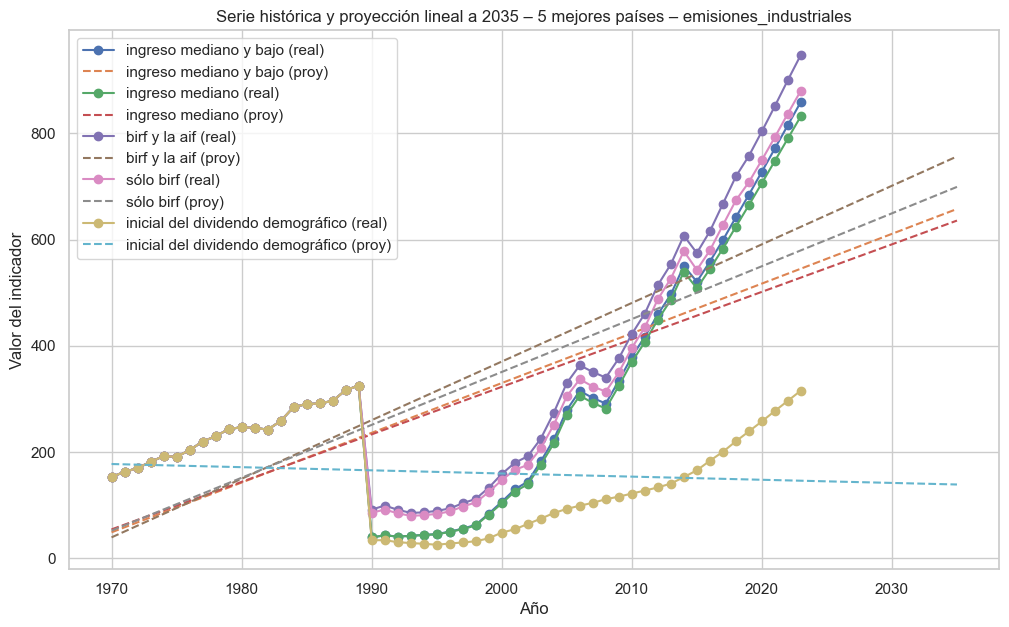


>>> Procesando indicador 3: servicios_sanitarios
Países modelados: 265
Guardado: salidas_modelado/proyecciones_lineales_2035_servicios_sanitarios.csv


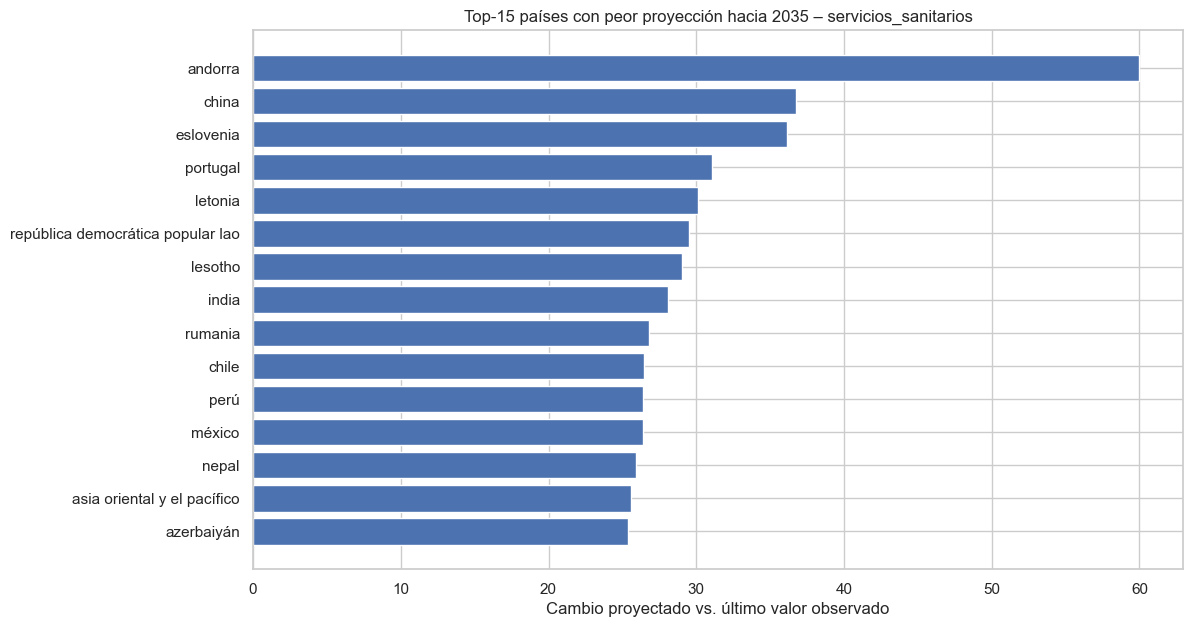

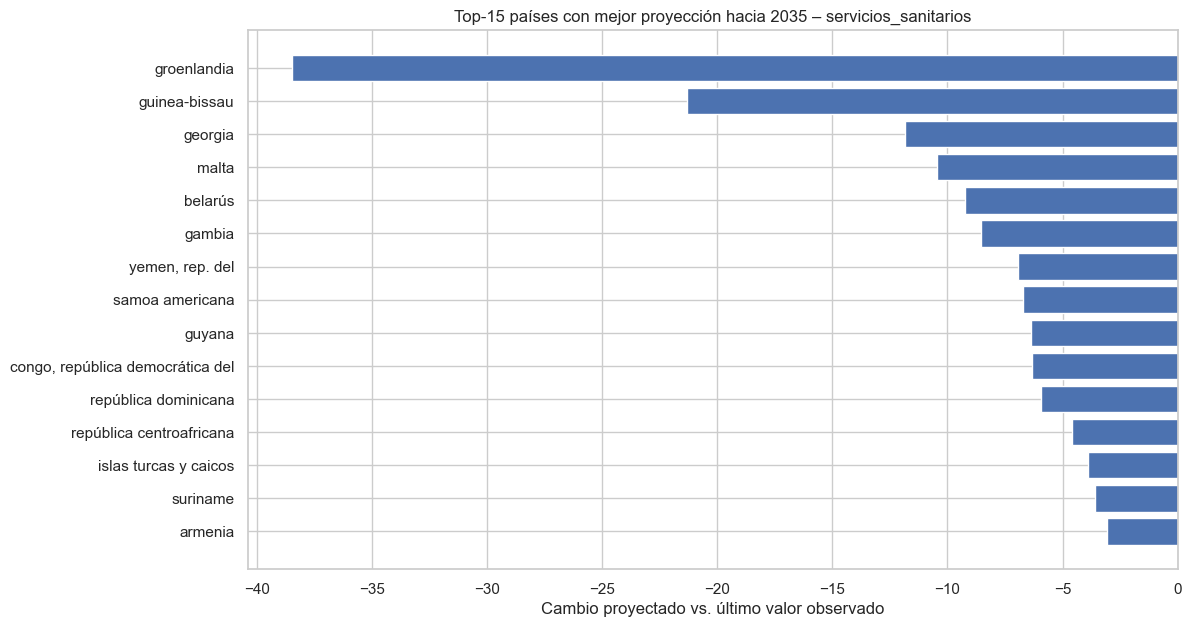

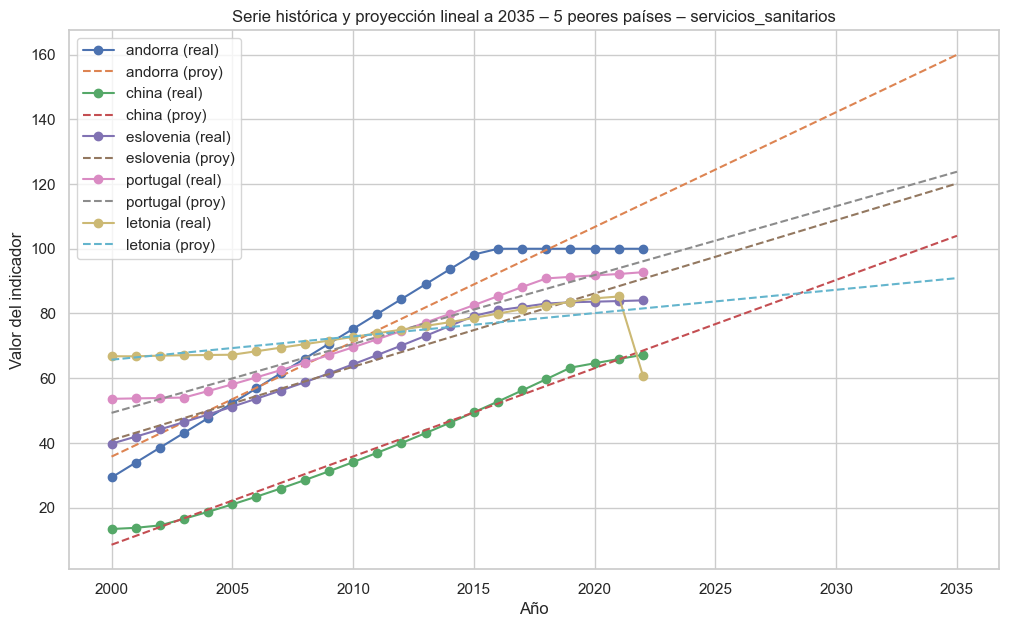

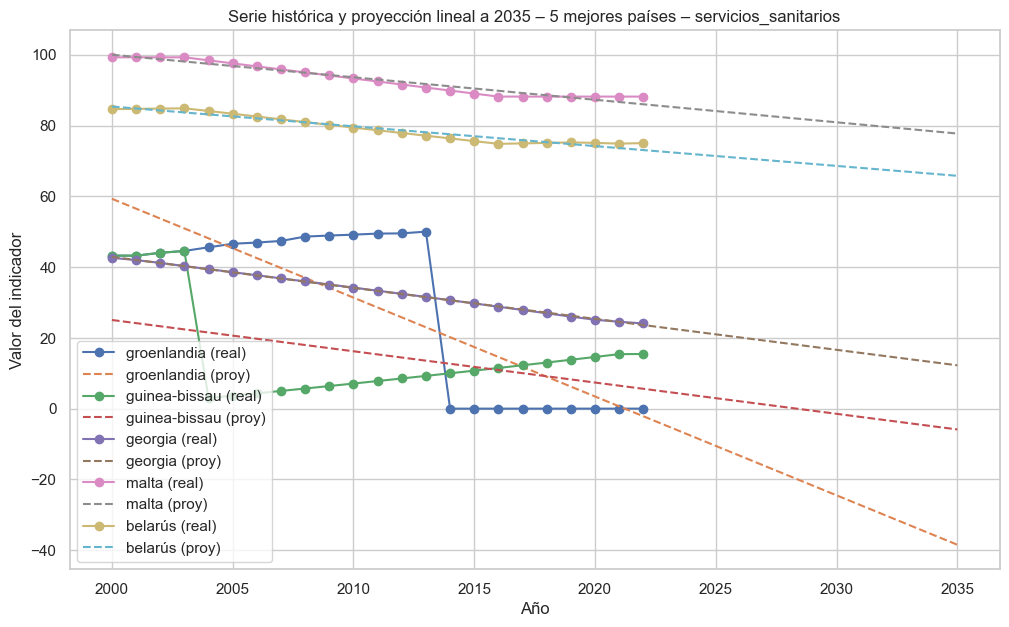

In [75]:
for i, df_def in enumerate(dataframes_long):
    print(f"\n>>> Procesando indicador {i}: {indicadores[i]}")
    
    resultados = []
    for pais, g in df_def.groupby("Country Name"):
        g = g.dropna(subset=["Value"])
        if g.shape[0] < min_puntos_por_pais:
            continue
        
        met = proyectar_pais(g, anio_hasta=anio_horizonte)
        if met is None:
            continue
        
        resultados.append({
            "Country Name": pais,
            "Country Code": g["Country Code"].iloc[0],
            "Indicator Name": g["Indicator Name"].iloc[0],
            "anio_min": met["anio_min"],
            "anio_max": met["anio_max"],
            "valor_ultimo": met["valor_ultimo"],
            "y2030": met["y2030"],
            "y2035": met["y2035"],
            "pendiente_por_anio": met["pendiente_por_anio"],
            "delta_2035_vs_ultimo": met["delta_2035_vs_ultimo"]
        })
    
    proyecciones = pd.DataFrame(resultados)
    print("Países modelados:", proyecciones.shape[0])

    if proyecciones.empty:
        print(f"Sin datos suficientes para {indicadores[i]}.")
        continue
    
    # Guardar CSV
    salida_csv = f"salidas_modelado/proyecciones_lineales_2035_{indicadores[i]}.csv"
    proyecciones.to_csv(salida_csv, index=False)
    print(f"Guardado: {salida_csv}")
    
    # Rankings (peor y mejor)
    if indicador_es_perdida:
        ranking_peor = proyecciones.sort_values("delta_2035_vs_ultimo", ascending=False)
        ranking_mejor = proyecciones.sort_values("delta_2035_vs_ultimo", ascending=True)
    else:
        ranking_peor = proyecciones.sort_values("delta_2035_vs_ultimo", ascending=True)
        ranking_mejor = proyecciones.sort_values("delta_2035_vs_ultimo", ascending=False)

    ranking_top15_peor = ranking_peor.head(15)
    ranking_top15_mejor = ranking_mejor.head(15)

    # Barras: peores
    plt.figure(figsize=(12, 7))
    plt.barh(ranking_top15_peor["Country Name"], ranking_top15_peor["delta_2035_vs_ultimo"])
    plt.gca().invert_yaxis()
    plt.title(f"Top-15 países con peor proyección hacia {anio_horizonte} – {indicadores[i]}")
    plt.xlabel("Cambio proyectado vs. último valor observado")
    plt.ylabel("")
    plt.show()

    # Barras: mejores
    plt.figure(figsize=(12, 7))
    plt.barh(ranking_top15_mejor["Country Name"], ranking_top15_mejor["delta_2035_vs_ultimo"])
    plt.gca().invert_yaxis()
    plt.title(f"Top-15 países con mejor proyección hacia {anio_horizonte} – {indicadores[i]}")
    plt.xlabel("Cambio proyectado vs. último valor observado")
    plt.ylabel("")
    plt.show()

    # --- Gráfico detallado: series históricas + proyección (5 peores) ---
    paises_clave = ranking_top15_peor["Country Name"].head(5).dropna().tolist()
    if len(paises_clave) == 0:
        print(f"No hay países suficientes para gráfico detallado en {indicadores[i]}")
        continue

    plt.figure(figsize=(12, 7))
    for pais in paises_clave:
        g = (
            df_def[df_def["Country Name"] == pais]
            .dropna(subset=["Value"])
            .sort_values("Year")
        )
        if g.shape[0] < 2:
            continue

        # Serie real
        plt.plot(g["Year"], g["Value"], marker="o", label=f"{pais} (real)")

        # Proyección lineal hasta anio_horizonte
        X = g["Year"].values.reshape(-1, 1)
        y = g["Value"].values
        model = LinearRegression().fit(X, y)

        years_proj = np.arange(g["Year"].min(), anio_horizonte + 1)
        yhat = model.predict(years_proj.reshape(-1, 1))
        plt.plot(years_proj, yhat, linestyle="--", label=f"{pais} (proy)")

    plt.title(f"Serie histórica y proyección lineal a {anio_horizonte} – 5 peores países – {indicadores[i]}")
    plt.xlabel("Año")
    plt.ylabel("Valor del indicador")
    plt.legend()
    plt.show()

    # --- Gráfico detallado: series históricas + proyección (5 mejores) ---
    paises_clave = ranking_top15_mejor["Country Name"].head(5).dropna().tolist()

    if len(paises_clave) == 0:
        print(f"No hay países suficientes para gráfico detallado en {indicadores[i]}")
    else:
        plt.figure(figsize=(12, 7))

        for pais in paises_clave:
            g = (
                df_def[df_def["Country Name"] == pais]
                .dropna(subset=["Value"])
                .sort_values("Year")
            )
            if g.shape[0] < 2:
                continue

            # Serie real
            plt.plot(g["Year"], g["Value"], marker="o", label=f"{pais} (real)")

            # Proyección lineal hasta anio_horizonte
            X = g["Year"].values.reshape(-1, 1)
            y = g["Value"].values
            model = LinearRegression().fit(X, y)

            years_proj = np.arange(g["Year"].min(), anio_horizonte + 1)
            yhat = model.predict(years_proj.reshape(-1, 1))
            plt.plot(years_proj, yhat, linestyle="--", label=f"{pais} (proy)")

        plt.title(f"Serie histórica y proyección lineal a {anio_horizonte} – 5 mejores países – {indicadores[i]}")
        plt.xlabel("Año")
        plt.ylabel("Valor del indicador")
        plt.legend()
        plt.show()